A while ago (in december) I had a meeting with stephen, these were some points raised
1. (done) Better reject high spurious center of mass values. The discrimination criterion should be based on a minimum number
of significant bins for the dprime based on a chance cutout
2. Do most of the analysis should on cell-probe pairs (use id_probe in DF)
3. are contextual effects independent of  probe?? if for one probe there are contextual effects, is there expected that
they also exist for other probes?
4 for the region comparisons, do them independently for each transition pair, as pooling across all of them might be
averaging out the effects, when there is no significant contextual effects.
5. conversely, for comparison of the effects of context transitions, further discriminate based on region
6. For a probe, display differences between context with a node-edge graph.


In [1]:
import itertools as itt
from pathlib import Path
from configparser import ConfigParser
from textwrap import fill

import joblib as jl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sst
import seaborn as sns
from cycler import cycler
from ipywidgets import interact, fixed

from src.data.region_map import region_map
from src.metrics.dprime import flip_dprimes
from src.metrics.consolidated_dprimes_v2 import single_cell_dprimes, probewise_LDA_dprimes, probewise_dPCA_dprimes, full_dPCA_dprimes
from src.metrics.consolidated_metrics import _append_means_to_array, metrics_to_DF
from src.metrics.significance import _significance, _mask_with_significance

[nems.configs.defaults INFO] Saving log messages to /tmp/nems/NEMS 2021-03-01 201116.log


In [2]:


plt.style.use('dark_background')
# modify figure color cycler back to the default one
color_cycler = cycler(color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                            '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])

params = {'legend.fontsize': 'medium',
          'axes.labelsize': 15,
          'axes.titlesize': 20,
          'axes.spines.top': False,
          'axes.spines.right': False,
          'axes.prop_cycle': color_cycler,
          'xtick.labelsize': 11,
          'ytick.labelsize': 11,
          'lines.markersize': 8,
          'figure.titlesize': 30,
          'figure.figsize': [6,6],
          'figure.autolayout':True,
          'svg.fonttype': 'none',
          'font.sans-serif': 'Arial'
          }

plt.rcParams.update(params)

In [3]:
config = ConfigParser()
config.read_file(open(Path('../config/settings.ini')))

In [4]:
# pulls DF, removes unused columns and data, refactor redunant id columns and create probe_id
rawDF = jl.load(Path('../data/consolidated_summary_DF_v2/dprime_absolute-None_montecarlo-1000_raster_fs-30_reliability-0.1_smoothing_window-0_zscore-True'))

ff_mult_corr = rawDF.mult_comp_corr == 'full'
ff_mean_signif = rawDF.mean_signif_type == 'zeros'

print(rawDF.columns)
DF = rawDF.loc[ff_mean_signif & ff_mult_corr,:]
DF['id'] = DF['cellid'].fillna(value=DF['siteid'])
DF['id_probe'] = DF[['id', 'probe']].agg('_'.join, axis=1)

DF = DF.drop(columns=['mult_comp_corr', 'mean_signif_type', 'cellid', 'siteid'])

print('duplicated columns?: ', any(DF.duplicated()))
print(DF.head(10))

Index(['cellid', 'context_pair', 'probe', 'value', 'metric', 'mult_comp_corr',
       'mean_signif_type', 'stim_type', 'analysis', 'siteid', 'region'],
      dtype='object')
duplicated columns?:  False
  context_pair probe    value                       metric     stim_type  \
0          0_1     1  33.3333  significant_abs_mass_center  permutations   
1          0_1     1        0  significant_abs_mass_center  permutations   
2          0_1     1        0  significant_abs_mass_center  permutations   
3          0_1     1   61.257  significant_abs_mass_center  permutations   
4          0_1     1        0  significant_abs_mass_center  permutations   
5          0_1     1  34.2072  significant_abs_mass_center  permutations   
6          0_1     1        0  significant_abs_mass_center  permutations   
7          0_1     1  24.2631  significant_abs_mass_center  permutations   
8          0_1     1  272.591  significant_abs_mass_center  permutations   
9          0_1     1        0  signifi

/auto/users/mateo/miniconda3/envs/context_probe_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/auto/users/mateo/miniconda3/envs/context_probe_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


## parameter space scaterplots
### for context and probe means

False


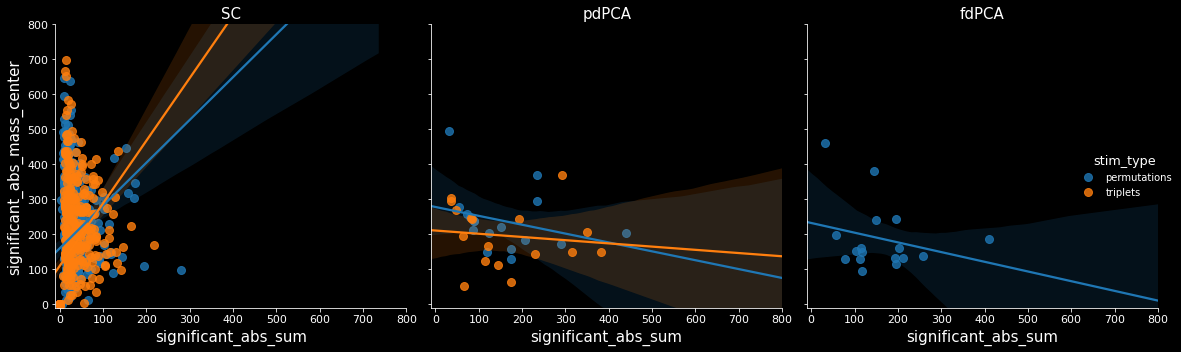

In [5]:
ff_ctx = DF.context_pair == 'mean'
ff_prb = DF.probe == 'mean'
good_cols = [col for col in DF.columns if col not in ['value', 'id_probe', 'probe', 'context_pair']]
pivot_cols = [col for col in good_cols if col not in ['value', 'metric']]

filtered = DF.loc[ff_ctx & ff_prb,:]
print(any(filtered.loc[:,good_cols].duplicated()))
toplot = filtered.pivot_table(index=pivot_cols, columns='metric', values='value', aggfunc='first').reset_index()
# note that 'LDA' can be added the the col_order
g = sns.lmplot(x='significant_abs_sum', y='significant_abs_mass_center',data=toplot, col='analysis', hue='stim_type',
               col_order=['SC', 'pdPCA', 'fdPCA'],sharex=True, sharey=True)
ax = g.axes[0,0]
ax.set_xlim(-10,800)
ax.set_ylim(-10,800)

g.set_titles(template="")
g._margin_titles = True
g.set_titles(row_template="{row_name}", col_template="{col_name}")



### same as before but for id_probes

False


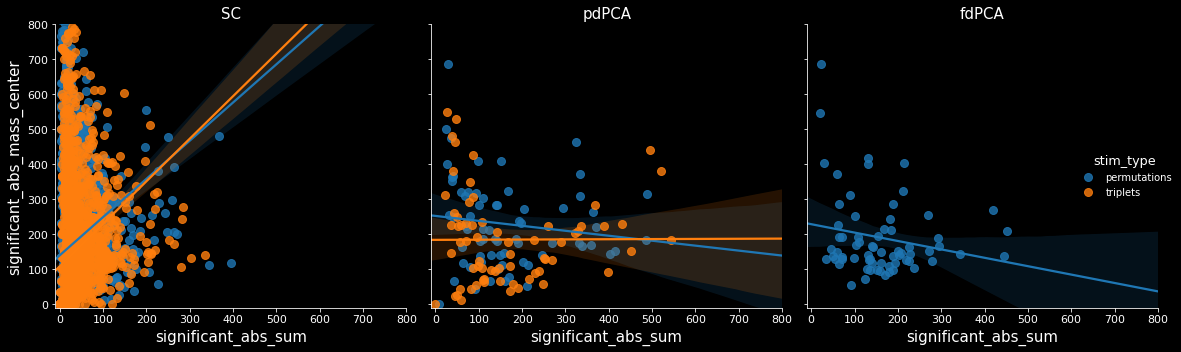

In [6]:
ff_ctx = DF.context_pair == 'mean'
ff_prb = DF.probe != 'mean'
good_cols = [col for col in DF.columns if col not in ['value', 'probe', 'context_pair', 'id']]
pivot_cols = [col for col in good_cols if col not in ['value', 'metric']]

filtered = DF.loc[ff_ctx & ff_prb,:]
print(any(filtered.loc[:,good_cols].duplicated()))
toplot = filtered.pivot_table(index=pivot_cols, columns='metric', values='value', aggfunc='first').reset_index()
# note that 'LDA' can be added the the col_order
g = sns.lmplot(x='significant_abs_sum', y='significant_abs_mass_center',data=toplot, col='analysis', hue='stim_type',
               col_order=['SC', 'pdPCA', 'fdPCA'],sharex=True, sharey=True)
ax = g.axes[0,0]
ax.set_xlim(-10,800)
ax.set_ylim(-10,800)

g.set_titles(template="")
g._margin_titles = True
g.set_titles(row_template="{row_name}", col_template="{col_name}")

It  looks similar to previous results, however the dimensionality reduction approaches are quite the lackluster when
comparing with the mean policy for the mean signficance. Not much to do here. perhaps see the raw dprime traces
of some of the outliers

In [7]:
# get some outlierse for SC and dPCA with low integral and high center of mass

ff_ctx = DF.context_pair == 'mean'
ff_prb = DF.probe == 'mean'
ff_analysis = DF.analysis.isin(['SC', 'pdPCA', 'fdPCA'])
ff_stim = DF.stim_type == 'permutations'


goodcols = [col for col in DF.columns if col not in ['value', 'metric', 'id_probe']]
filtered = DF.loc[ff_ctx & ff_prb & ff_analysis & ff_stim,:]
# print(any(filtered.duplicated()))
pivoted = filtered.pivot_table(index=goodcols, columns='metric', values='value', aggfunc='first').reset_index()
sorted = pivoted.sort_values(['significant_abs_mass_center', 'significant_abs_sum'], axis=0, ascending=[0,1])

print(sorted.head(10))

metric context_pair probe     stim_type analysis region            id  \
332            mean  mean  permutations       SC    PEG  AMT030a-09-4   
328            mean  mean  permutations       SC    PEG  AMT030a-03-2   
248            mean  mean  permutations       SC     A1  ley075b-12-1   
385            mean  mean  permutations       SC    PEG  CRD011c-30-3   
281            mean  mean  permutations       SC    PEG  AMT028b-04-1   
46             mean  mean  permutations       SC     A1  CRD002a-11-1   
256            mean  mean  permutations       SC    PEG  AMT026a-04-4   
74             mean  mean  permutations       SC     A1  CRD002a-42-4   
458            mean  mean  permutations    pdPCA     A1       ley075b   
381            mean  mean  permutations       SC    PEG  CRD011c-17-1   

metric  significant_abs_mass_center  significant_abs_sum  
332                      647.493786            10.247940  
328                      639.097528            24.014888  
248                

there are plenty of culprits for single cell, and a couple for dPCA:
* dPCA, ley075b
* dPCA, CRD012b
* SC, AMT030a-09-4
* SC, AMT030a-03-2

It is worth plotting the raw dprime traces and perhaps thinking a new significance correction... at least the function
already exists and should be easy to exted.


13 -1 -1


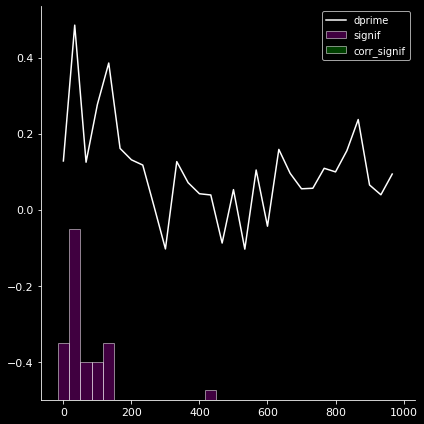

In [8]:
# @interact(cell=(0,41), ctx_pair=(0,9), probe=(0,3))
# def plot_example(cell, ctx_pair, probe):

permutations = {'contexts': [0, 1, 2, 3, 4],
                'probes': [1, 2, 3, 4],
                'stim_type': 'permutations'}

triplets = {'contexts': ['silence', 'continuous', 'similar', 'sharp'],
            'probes':[2, 3, 5, 6],
            'stim_type': 'triplets'}

analysis_functions = {'SC': single_cell_dprimes,'LDA':probewise_LDA_dprimes,
                      'pdPCA': probewise_dPCA_dprimes, 'fdPCA': full_dPCA_dprimes}

experiments = {'permutations':permutations, 'triplets':triplets}




site = 'AMT030a'
cellid = 'AMT030a-09-4'
cellid = 'AMT030a-22-1'
expt_name = 'permutations'
fname = 'SC'
ctx_pair = 'mean'
probe = 'mean'
mult_corr = 'full'

multiple_corrections = {'none': (None, None),
                        'full': ([1,2,3], None),
                        'time': ([3], None),
                        'probe': ([2,3], None),
                        'context_pair': ([1,3], None),
                        'consecutive_2': ([3], 2),
                        'consecutive_3': ([3], 3),
                        'consecutive_4': ([3], 4)}

corr, cons = multiple_corrections[mult_corr]
alpha = 0.1

mean_type = 'zeros'

if ctx_pair == 'mean':
    ctx_pair = -1
if probe == 'mean':
    probe = -1

meta = {'reliability': 0.1,  # r value
        'smoothing_window': 0,  # ms
        'raster_fs': 30,
        'montecarlo': 1000,
        'zscore': True,
        'dprime_absolute': None}


func = analysis_functions[fname]
expt = experiments[expt_name].copy()
meta['stim_type'] = expt.pop('stim_type')

dprime, shuffled_dprime, goodcells, var_capt = func(site, **expt, meta=meta)

if fname != 'SC':
    chan_name = [np.nan]
    cell = 0
else:
    chan_name = goodcells
    cell = goodcells.index(cellid)

# creates label dictionalry
t = np.linspace(0, dprime.shape[-1] / meta['raster_fs'], dprime.shape[-1],
                                    endpoint=False) * 1000
dim_lab_dict = {'cellid': chan_name,
                'context_pair': [f'{c1}_{c2}' for c1, c2 in itt.combinations(expt['contexts'], 2)],
                'probe': expt['probes'],
                'time': t}

signif, _ = _significance(dprime, shuffled_dprime, None, None, alpha=alpha)
corr_siginif, CI = _significance(dprime, shuffled_dprime, corr, cons, alpha=alpha)
fliped, _ = flip_dprimes(dprime, None, flip='sum')
dprime_means, _ = _append_means_to_array(fliped, dim_lab_dict)

masked, masked_lab_dict = _mask_with_significance(fliped, corr_siginif, dim_lab_dict, mean_type=mean_type)
signif_means,_ = _append_means_to_array(signif, dim_lab_dict)
corr_signif_means,_ = _append_means_to_array(corr_siginif, dim_lab_dict)


fig, ax = plt.subplots()
print(cell, ctx_pair, probe)
_ = ax.plot(t, dprime_means[cell, ctx_pair, probe, :], color='white', label='dprime')

if (ctx_pair != -1) and (probe != -1):
    _ = ax.fill_between(t, CI[0, cell, ctx_pair, probe, :], CI[1,cell, ctx_pair, probe, :],
                    color='gray', alpha=0.5, label=f'{(1-alpha)*100}% confidence interval')

ax_bott = -0.5
_ = ax.bar(t, signif_means[cell, ctx_pair, probe, :], width=1000/30, align='center', color='purple',
       edgecolor='white', bottom=ax_bott, alpha=0.5, label='signif')

_ = ax.bar(t, corr_signif_means[cell, ctx_pair, probe, :], width=1000/30, align='center', color='green',
       edgecolor='white', bottom=ax_bott, alpha=0.5, label='corr_signif')

_ = ax.legend()
# return fig, ax

now show all combinations of context_pair, probe

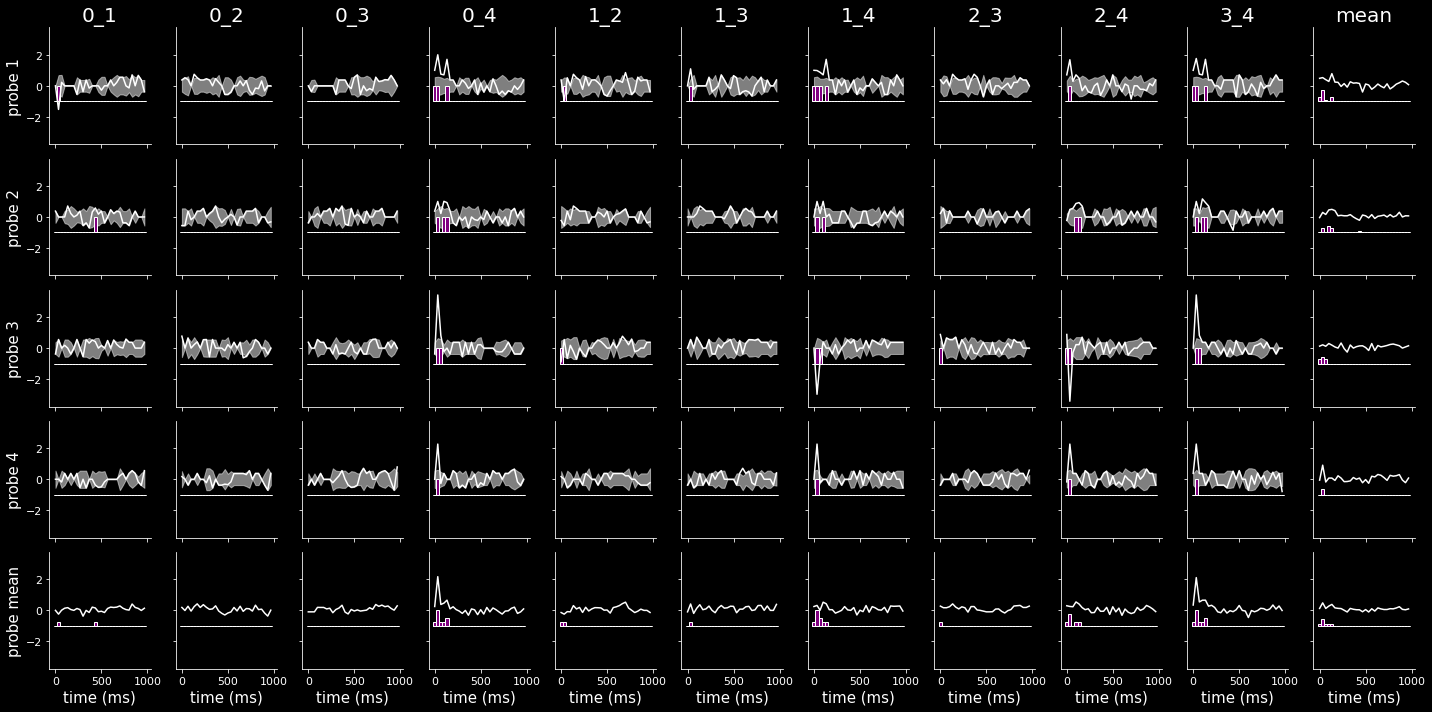

In [9]:
# def category_summary_plot(id, experiment,):
"""
Plots calculated dprime, confidense interval of shuffled dprime, and histogram of significant bins, for all contexts
and probes.
Subplots are a grid of al combinations of probe (rows) and context pairs (columns), plus the means of each category,
and the grand mean
:param id: str. cell or site id
:param source: str. 'SC', 'dPCA', or 'LDA'
:return: fig, axes.
"""

func = analysis_functions[fname]
expt = experiments[expt_name].copy()
meta['stim_type'] = expt.pop('stim_type')

dprime, shuffled_dprime, goodcells, var_capt = func(site, **expt, meta=meta)

if fname != 'SC':
    chan_name = [np.nan]
    cell = 0
else:
    chan_name = goodcells
    cell = goodcells.index(cellid)

# creates label dictionalry
t = np.linspace(0, dprime.shape[-1] / meta['raster_fs'], dprime.shape[-1],
                                    endpoint=False) * 1000
dim_lab_dict = {'cellid': chan_name,
                'context_pair': [f'{c1}_{c2}' for c1, c2 in itt.combinations(expt['contexts'], 2)],
                'probe': expt['probes'],
                'time': t}

signif, _ = _significance(dprime, shuffled_dprime, None, None, alpha=alpha)
corr_siginif, CI = _significance(dprime, shuffled_dprime, corr, cons, alpha=alpha)
fliped, _ = flip_dprimes(dprime, None, flip='sum')
dprime_means, meaned_dict = _append_means_to_array(fliped, dim_lab_dict)

masked, masked_lab_dict = _mask_with_significance(fliped, corr_siginif, dim_lab_dict, mean_type=mean_type)
signif_means,_ = _append_means_to_array(signif, dim_lab_dict)
corr_signif_means,_ = _append_means_to_array(corr_siginif, dim_lab_dict)

# flips signs of dprimes and montecarlos as neede
dprimes = dprime_means
shuffleds =  CI
signif_bars = signif_means

t = dim_lab_dict['time']

bar_bottom = -1
bar_width = 1000/30

fig, axes = plt.subplots(len(meaned_dict['probe']), len(meaned_dict['context_pair']),
                         sharex='all', sharey='all', figsize=(20,10))
for (tt, trans_pair),(pp, probe) in itt.product(enumerate(meaned_dict['context_pair']), enumerate(meaned_dict['probe'])):

    # plots the real dprime and the shuffled dprime
    axes[pp, tt].plot(t, dprimes[cell, tt, pp, :], color='white')

    axes[pp, tt].bar(t, signif_means[cell, tt, pp, :], width=bar_width, align='center', color='purple',
                 edgecolor='white', bottom=bar_bottom, label='signif')

    axes[pp, tt].bar(t, corr_signif_means[cell, tt, pp, :], width=bar_width, align='center', color='green',
             edgecolor='white', bottom=bar_bottom, label='corr_signif')


    if (tt != len(meaned_dict['context_pair'])-1) and (pp != len(meaned_dict['probe'])-1):
        axes[pp, tt].fill_between(t, shuffleds[0, cell, tt, pp, :], shuffleds[1, cell, tt, pp, :], color='white', alpha=0.5)


# formats axis, legend and so on.
for pp, probe in enumerate(meaned_dict['probe']):
    axes[pp, 0].set_ylabel(f'probe {probe}')

for tt, trans in enumerate(meaned_dict['context_pair']):
    axes[0, tt].set_title(trans)
    axes[-1, tt].set_xlabel('time (ms)')

for ax in np.ravel(axes):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
fig.tight_layout()
# return fig, axes


try again


In [10]:

def plot_signif_summary(site, expt_name, fname, corr_name, mean_type, cellid=None):
    alpha=0.01
    meta = {'reliability': 0.1,  # r value
            'smoothing_window': 0,  # ms
            'raster_fs': 30,
            'montecarlo': 1000,
            'zscore': True,
            'dprime_absolute': None}

    analysis_functions = {'SC': single_cell_dprimes,'LDA':probewise_LDA_dprimes,
                          'pdPCA': probewise_dPCA_dprimes, 'fdPCA': full_dPCA_dprimes}


    permutations = {'contexts': [0, 1, 2, 3, 4],
                    'probes': [1, 2, 3, 4],
                    'stim_type': 'permutations'}

    triplets = {'contexts': ['silence', 'continuous', 'similar', 'sharp'],
                'probes':[2, 3, 5, 6],
                'stim_type': 'triplets'}

    experiments = {'permutations':permutations, 'triplets':triplets}

    multiple_corrections = {'none': (None, None),
                            'full': ([1,2,3], None),
                            'time': ([3], None),
                            'probe': ([2,3], None),
                            'context_pair': ([1,3], None),
                            'consecutive_2': ([3], 2),
                            'consecutive_3': ([3], 3),
                            'consecutive_4': ([3], 4)}



    expt = experiments[expt_name]
    func = analysis_functions[fname]
    corr, cons = multiple_corrections[corr_name]



    # skips full_dPCA for the triplets experiment
    if expt['stim_type'] == 'triplets' and fname == 'fdPCA':
        print('invalid combination.  Triplets cant use fdPCA')

    print(site, expt['stim_type'], fname)

    # parses the stim_type from the experiment into the meta parameters
    expt = expt.copy()
    meta['stim_type'] = expt.pop('stim_type')

    # runs the dprime function
    dprime, shuffled_dprime, goodcells, var_capt = func(site, **expt, meta=meta)

    # for analysis with dimensionality reduction, changes the cellname to nan for proper dimension labeling.
    if fname != 'SC':
        chan_name = [np.nan]
    else:
        chan_name = goodcells

    # creates label dictionalry
    dim_lab_dict = {'cellid': chan_name,
                    'context_pair': [f'{c1}_{c2}' for c1, c2 in itt.combinations(expt['contexts'], 2)],
                    'probe': expt['probes'],
                    'time': np.linspace(0, dprime.shape[-1] / meta['raster_fs'], dprime.shape[-1],
                                        endpoint=False) * 1000}

    # calculats different significaces/corrections
    # calculate significant time bins, both raw and corrected for multiple comparisons
    raw_sig, _ = _significance(dprime, shuffled_dprime, None, None, alpha)
    significance, confidence_interval = _significance(dprime, shuffled_dprime, corr, cons, alpha)
    fliped, _ = flip_dprimes(dprime, None, flip='sum')

    # masks dprime with different significances, uses different approaches to define significance of the mean.
    print(mean_type)
    masked, masked_lab_dict = _mask_with_significance(fliped, significance, dim_lab_dict, mean_type=mean_type)

    # calculate different metrics and organize into a dataframe
    df = metrics_to_DF(masked, masked_lab_dict, metrics=['significant_abs_mass_center', 'significant_abs_sum'])
    return df, fliped, shuffled_dprime, significance, masked, masked_lab_dict


    #
    # #
    # for (tt, trans_pair),(pp, probe) in itt.product(enumerate(meaned_dict['context_pair']), enumerate(meaned_dict['probe'])):
    #
    #     # plots the real dprime and the shuffled dprime
    #     axes[pp, tt].plot(t, dprimes[cell, tt, pp, :], color='white')
    #
    #     axes[pp, tt].bar(t, signif_means[cell, tt, pp, :], width=bar_width, align='center', color='purple',
    #                  edgecolor='white', bottom=bar_bottom, label='signif')
    #
    #     axes[pp, tt].bar(t, corr_signif_means[cell, tt, pp, :], width=bar_width, align='center', color='green',
    #              edgecolor='white', bottom=bar_bottom, label='corr_signif')
    #
    #
    #     if (tt != len(meaned_dict['context_pair'])-1) and (pp != len(meaned_dict['probe'])-1):
    #         axes[pp, tt].fill_between(t, shuffleds[0, cell, tt, pp, :], shuffleds[1, cell, tt, pp, :], color='white', alpha=0.5)
    #
    #
    # # formats axis, legend and so on.
    # for pp, probe in enumerate(meaned_dict['probe']):
    #     axes[pp, 0].set_ylabel(f'probe {probe}')
    #
    # for tt, trans in enumerate(meaned_dict['context_pair']):
    #     axes[0, tt].set_title(trans)
    #     axes[-1, tt].set_xlabel('time (ms)')
    #
    # for ax in np.ravel(axes):
    #     ax.spines['right'].set_visible(False)
    #     ax.spines['top'].set_visible(False)
    # fig.tight_layout()
    # # return fig, axes

cellid = 'AMT030a-09-4'
site = 'AMT030a'
expt_name = 'permutations'
fname = 'SC'
ctx_pair = 'mean'
probe = 'mean'
mult_corr = 'full'
mean_type = 'zeros'

df, test_dprime, test_shuf, test_signif, masked, masked_lab_dict  = plot_signif_summary(site, expt_name, fname, mult_corr, mean_type)

(29, 11, 5, 30)
{'cellid': ['AMT030a-03-1', 'AMT030a-03-2', 'AMT030a-04-1', 'AMT030a-07-2', 'AMT030a-09-1', 'AMT030a-09-4', 'AMT030a-09-5', 'AMT030a-10-3', 'AMT030a-17-1', 'AMT030a-19-2', 'AMT030a-21-1', 'AMT030a-21-3', 'AMT030a-21-4', 'AMT030a-22-1', 'AMT030a-22-2', 'AMT030a-23-1', 'AMT030a-23-2', 'AMT030a-24-1', 'AMT030a-24-2', 'AMT030a-25-1', 'AMT030a-27-1', 'AMT030a-27-2', 'AMT030a-28-1', 'AMT030a-28-2', 'AMT030a-28-3', 'AMT030a-30-1', 'AMT030a-30-2', 'AMT030a-31-1', 'AMT030a-32-1'], 'context_pair': ['0_1', '0_2', '0_3', '0_4', '1_2', '1_3', '1_4', '2_3', '2_4', '3_4', 'mean'], 'probe': [1, 2, 3, 4, 'mean'], 'time': array([  0.        ,  33.33333333,  66.66666667, 100.        ,
       133.33333333, 166.66666667, 200.        , 233.33333333,
       266.66666667, 300.        , 333.33333333, 366.66666667,
       400.        , 433.33333333, 466.66666667, 500.        ,
       533.33333333, 566.66666667, 600.        , 633.33333333,
       666.66666667, 700.        , 733.33333333, 766.6666

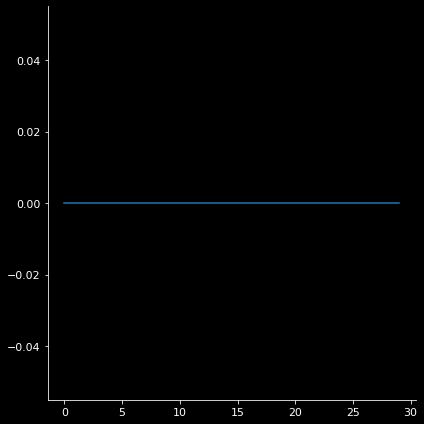

In [12]:
print(masked.shape)
print(masked_lab_dict)

fig, ax = plt.subplots()
_=ax.plot(masked[5, -1,-1,:].T)
egpath = Path('/home/mateo/fast_eg')
egflip, egshuf, egsig, egmask, egdict = jl.load(egpath)

In [13]:
print(test_shuf.shape)
print(egshuf.shape)
np.all(np.isclose(test_shuf,egshuf))

(1000, 29, 10, 4, 30)
(1000, 29, 10, 4, 30)


False

In [14]:
filt = df.loc[(df.context_pair == 'mean')&(df.probe == 'mean'),:]
piv = filt.pivot_table(index=['cellid', 'context_pair', 'probe'], columns='metric', values='value', aggfunc='first').reset_index()
sorted = piv.sort_values(['significant_abs_mass_center', 'significant_abs_sum'], axis=0, ascending=[0,1])
print(sorted)

metric        cellid context_pair probe  significant_abs_mass_center  \
13      AMT030a-22-1         mean  mean                    60.751774   
0       AMT030a-03-1         mean  mean                     0.000000   
1       AMT030a-03-2         mean  mean                     0.000000   
2       AMT030a-04-1         mean  mean                     0.000000   
3       AMT030a-07-2         mean  mean                     0.000000   
4       AMT030a-09-1         mean  mean                     0.000000   
5       AMT030a-09-4         mean  mean                     0.000000   
6       AMT030a-09-5         mean  mean                     0.000000   
7       AMT030a-10-3         mean  mean                     0.000000   
8       AMT030a-17-1         mean  mean                     0.000000   
9       AMT030a-19-2         mean  mean                     0.000000   
10      AMT030a-21-1         mean  mean                     0.000000   
11      AMT030a-21-3         mean  mean                     0.00

In [15]:
print(DF.columns)
print(site in DF.id.unique())
IND = DF.set_index(['id', 'stim_type', 'analysis', 'context_pair', 'probe'])
IND.loc[cellid, expt_name, fname, 'mean','mean']

Index(['context_pair', 'probe', 'value', 'metric', 'stim_type', 'analysis',
       'region', 'id', 'id_probe'],
      dtype='object')
True


/auto/users/mateo/miniconda3/envs/context_probe_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  after removing the cwd from sys.path.


value  \
id           stim_type    analysis context_pair probe            
AMT030a-09-4 permutations SC       mean         mean   647.494   
                                                mean   10.2479   

                                                                            metric  \
id           stim_type    analysis context_pair probe                                
AMT030a-09-4 permutations SC       mean         mean   significant_abs_mass_center   
                                                mean           significant_abs_sum   

                                                      region  \
id           stim_type    analysis context_pair probe          
AMT030a-09-4 permutations SC       mean         mean     PEG   
                                                mean     PEG   

                                                                id_probe  
id           stim_type    analysis context_pair probe                     
AMT030a-09-4 permutations SC       mean         mean   AMT030a-09-4_mean  
                                                mean   AMT030a-09-4_mean

In [16]:
ind = df.set_index(['cellid', 'context_pair', 'probe'])
ind.loc[cellid, 'mean', 'mean']
















/auto/users/mateo/miniconda3/envs/context_probe_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  


value                       metric
cellid       context_pair probe                                   
AMT030a-09-4 mean         mean      0  significant_abs_mass_center
                          mean      0          significant_abs_sum